# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

## Due: Midnight on March 30 (with 2-hour grace period) and worth 25 points





### What We Will Do in This Milestone Assignment

1. You will convene your team (listed on Blackboard) and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. The team leader should upload the notebook and then create a group on GS for the group submission.
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [465]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [466]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?

The objective of this project is to develop a data-driven model that accurately predicts housing prices based on key property attributes. This will help real estate professionals, investors, and home buyers make informed decisions about property valuation. Additionally, it aims to identify the most influential features affecting housing prices, enabling better pricing strategies and market analysis




**1.2:**  How will your solution be used?

- Providing accurate price estimates for buyers, sellers, and real estate agents.

- Assisting investors in identifying undervalued or overvalued properties.

- Understanding housing trends across different regions and counties.


**1.3:**  How should success (or failure) be measured?

Success can be measured by
- Ensuring that the model performs well on unseen data by assessing validation and test set performance.
- Checking whether the selected features (via F-score, forward, and backward selection) improve model interpretability and performance.
- Determining whether the model improves pricing decisions and reduces valuation errors

We would be able to indicate failure of the model if 
- If the model overfits the training data but performs poorly on validation/test data
- If the selected features (via F-score, forward selection, or backward selection) do not contribute significantly to the model’s predictive power, meaning if we see the key influential features are ignore as well
- If the models predictions do not significantly improve over basic pricing strategies



## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [467]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,3100.0,3100.0,NaN,NaN,NaN,NaN,6059.0,NaN,3.0,2.0,633.0,NaN,NaN,33634931.0,-117869207.0,4506.0,NaN,NaN,NaN,NaN,NaN,122,261.0,NaN,6.059063e+07,53571.0,1286.0,NaN,96978.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,1465.0,1465.0,1465.0,NaN,NaN,1465.0,NaN,6111.0,1.0,1.0,1.0,0.0,NaN,NaN,34449266.0,-119281531.0,12647.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,13091.0,2061.0,NaN,97099.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,NaN,1243.0,1243.0,NaN,NaN,NaN,NaN,6059.0,NaN,2.0,2.0,440.0,NaN,NaN,33886168.0,-117823170.0,8432.0,1.0,NaN,NaN,NaN,1.0,122,261.0,NaN,6.059022e+07,21412.0,1286.0,NaN,97078.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,NaN,2376.0,2376.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34245180.0,-118240722.0,13038.0,1.0,NaN,NaN,NaN,1.0,0101,261.0,LCR110000*,6.037300e+07,396551.0,3101.0,NaN,96330.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,NaN,1312.0,1312.0,NaN,NaN,NaN,NaN,6037.0,NaN,3.0,NaN,NaN,NaN,2.0,34185120.0,-118414640.0,278581.0,1.0,NaN,NaN,NaN,1.0,010C,266.0,LAR3,6.037124e+07,12447.0,3101.0,268548.0,96451.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [468]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [469]:
# This function will list how many nulls occur in which features

def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values,
        'UniqueCount': df.nunique()[count_nulls[count_nulls > 0].index].values
    }).sort_values(by='Null %', ascending=True)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name                  # Nulls      Null %    Type        UniqueCount')
        print('---------------------------    -------      ------    ----       -----------')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<30} {row['# Null Values']:<12} {row['Null %']:.2f}%   {row['Type']:<12} {row['UniqueCount']}")
#                                                                        

show_null_counts_features(df)

The dataset contains 77613 samples.

Feature Name                  # Nulls      Null %    Type        UniqueCount
---------------------------    -------      ------    ----       -----------
bathroomcnt                    34           0.04%   Numeric      22
bedroomcnt                     34           0.04%   Numeric      16
latitude                       34           0.04%   Numeric      64038
fips                           34           0.04%   Numeric      3
longitude                      34           0.04%   Numeric      62461
propertycountylandusecode      34           0.04%   Categorical  75
rawcensustractandblock         34           0.04%   Numeric      39188
propertylandusetypeid          34           0.04%   Numeric      13
regionidcounty                 34           0.04%   Numeric      3
roomcnt                        34           0.04%   Numeric      16
assessmentyear                 34           0.04%   Numeric      1
taxvaluedollarcnt              35           0.05%   Num

In [470]:
df.nunique().sort_values(ascending=False)

parcelid                        77414
latitude                        64038
longitude                       62461
taxvaluedollarcnt               50949
rawcensustractandblock          39188
censustractandblock             39006
lotsizesquarefeet               18848
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
propertyzoningdesc               1907
finishedsquarefeet50             1807
finishedfloor1squarefeet         1787
finishedsquarefeet15             1724
garagetotalsqft                   839
yardbuildingsqft17                540
regionidneighborhood              480
regionidzip                       389
finishedsquarefeet6               350
poolsizesum                       262
regionidcity                      175
yearbuilt                         136
propertycountylandusecode          75
yardbuildingsqft26                 59
basementsqft                       43
bathroomcnt                        22
calculatedbathnbr                  21
bedroomcnt  

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?
There are 5 categorical features - fireplaceflag, hashottuborspa, taxdelinquencyflag, propertyzoningdesc, propertycountylandusecode

In [471]:
categorical_features = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print("Categorical features:", categorical_features)


Categorical features: ['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']


**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

These are the features that seem useless at first glance, listed below the features and why i consider them useless 
1. parcelid  - This just seems like a unique identifier and has no meaning 
2. calculatedbathnbr - Seems like redundant , there are other features providig the bathroomcount 
3. finishedsquarefeet12, 13, 15, 50, 6 - This might be just too much information based on some domain knowledge. Buyer would be interested in finished square feet atleast for the initial round, these parameters shouldnt drastically impact price
4. .fips - seems irrelevant to the buyer
5. latitude, longitude - this seems redundant , the region related features should be able to tell the location
6. poolsizesum, pooltypeid10, 2 - maybe redundant information , as long as buyer knows if there is a pool or spa is enough information and shouldnt drastically change price
7. rawcensustractandblock - doesnt look like relevant info based on domain knowledge
8. fireplacecnt - Redundant since there is already a field called fireplace flag which will tell if there is a fireplace or not which should be sufficient 
9. censustrackandblock - seems irrelevant as well 

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

Yes, the feature 'finishedsquarefeet13'---99.95% missing value, and 'buildingclasstypeid'--- 99.98% missing value.

Based on the datatype, there features should be "object" or "Numeric".

The missing value is bool type, is not "NaN" or "N"

It is missing value

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

Yes, the feature "assessmentyear", even with only 0.04% missing vaule, but just one unique value, no distributsions.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

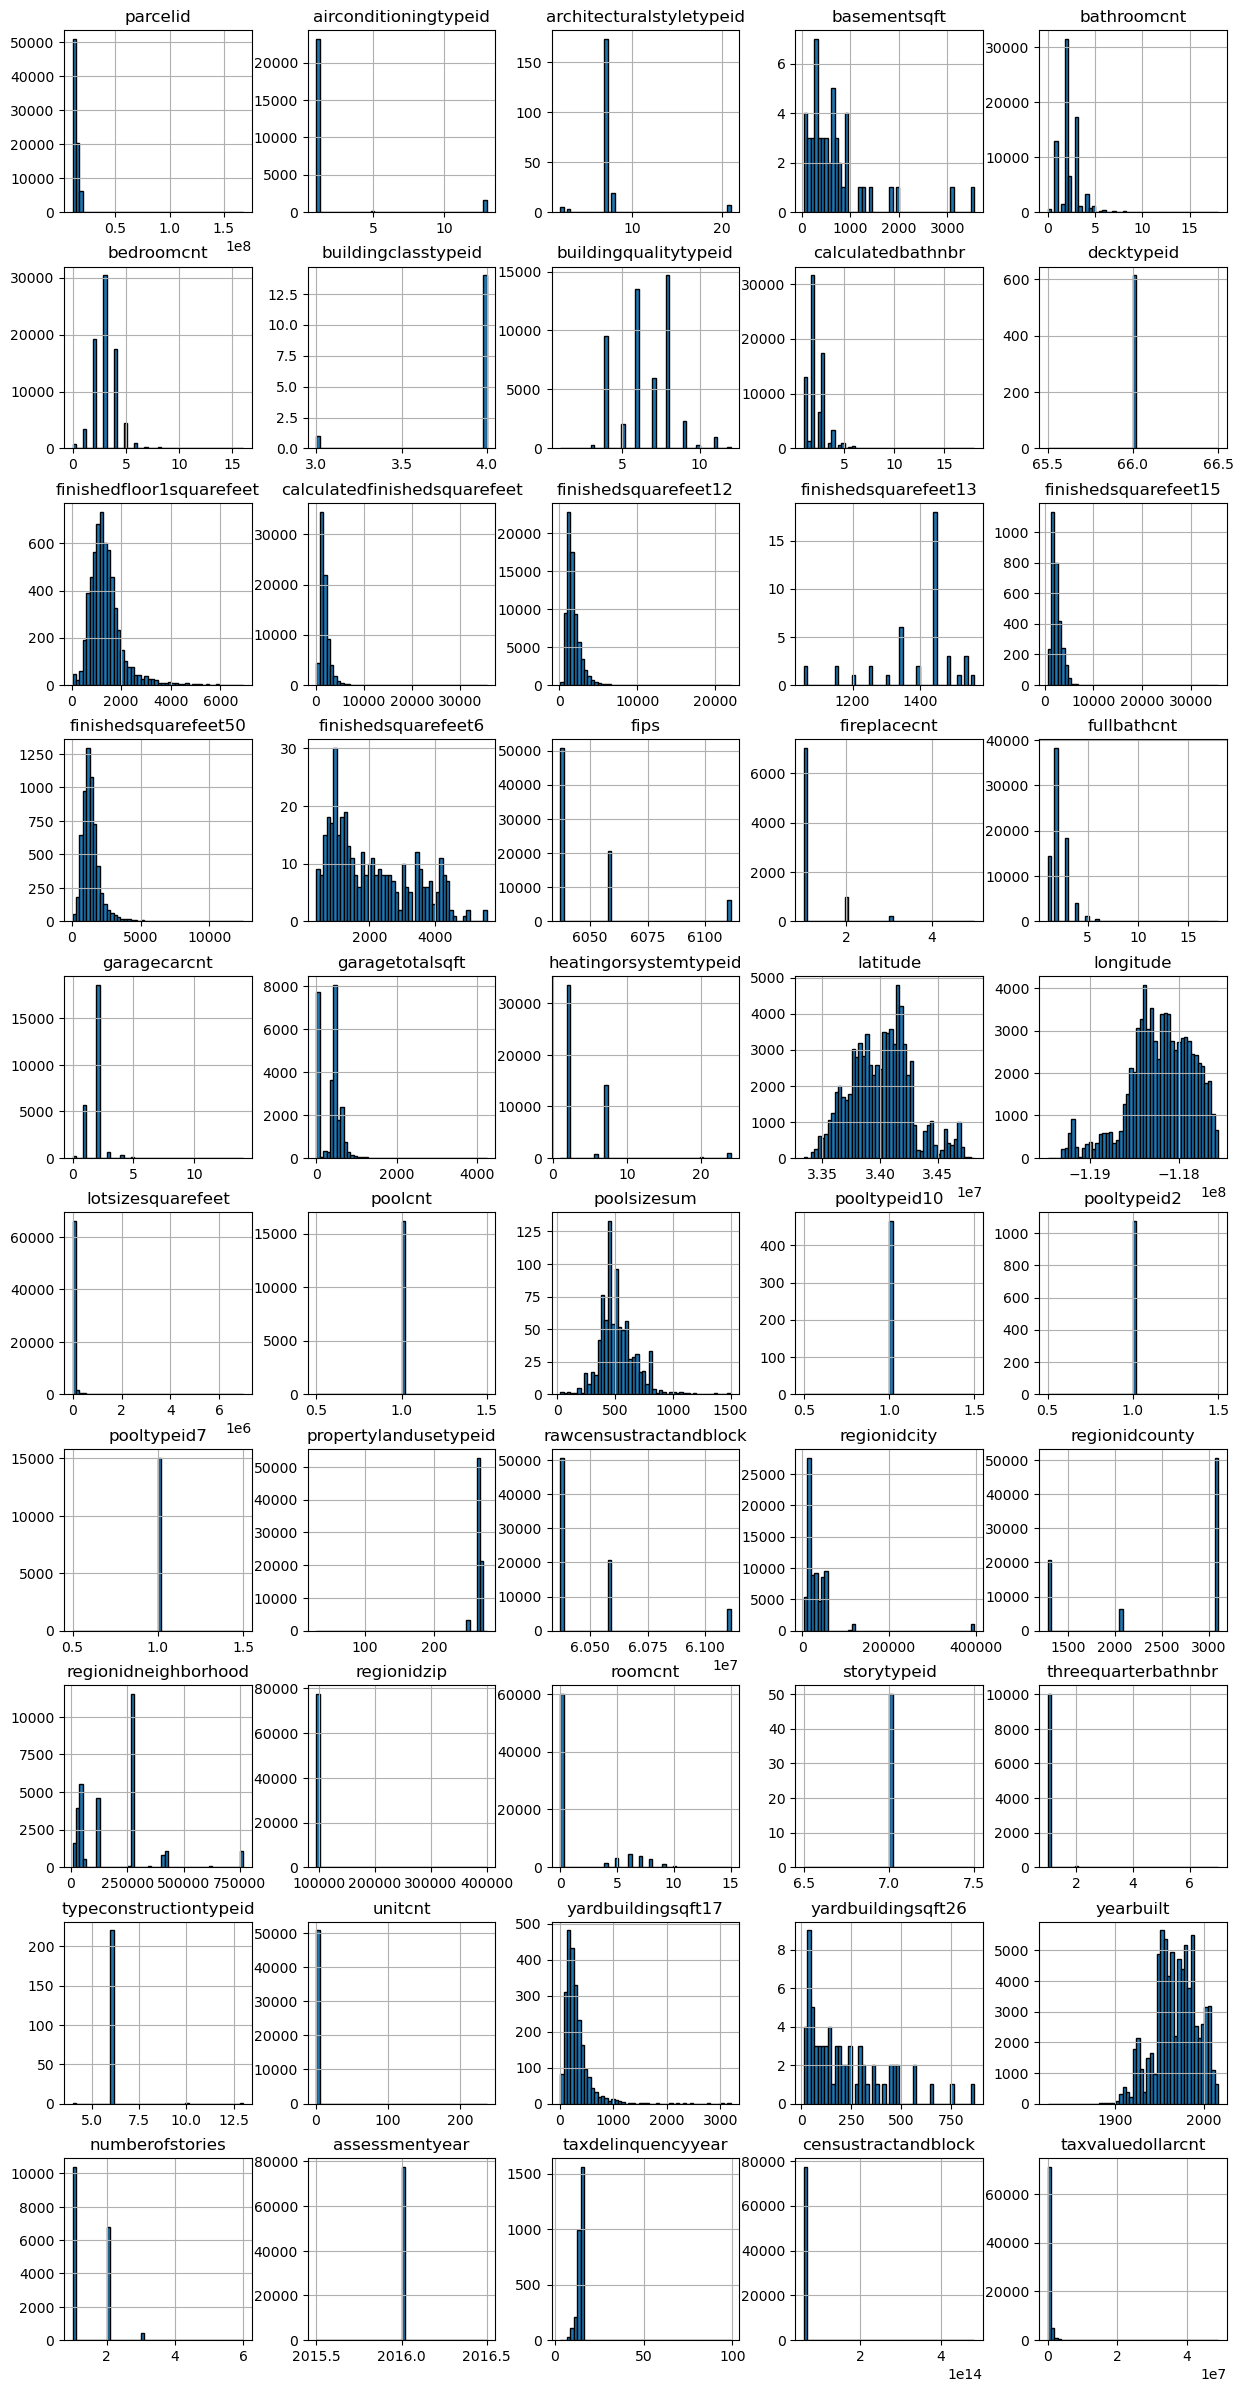

In [472]:
df.hist(figsize=(15,30), layout=(-1,5), bins=50, edgecolor ='black')
plt.show()


Feature: taxvaluedollarcnt
Mean: 490150.59
Median: 358878.50
Max: 49061236.0
Min: 1000.0


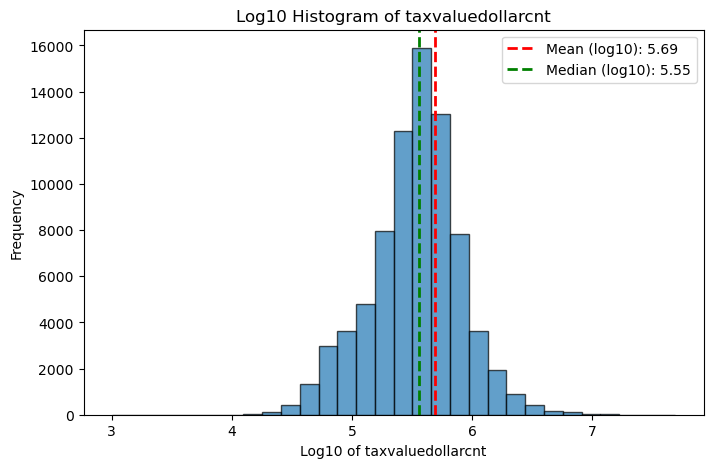

In [473]:


# Feature to analyze
feature = 'taxvaluedollarcnt'

# Print statistics
print(f"\nFeature: {feature}")
print(f"Mean: {df[feature].mean():.2f}")
print(f"Median: {df[feature].median():.2f}")
print(f"Max: {df[feature].max()}")
print(f"Min: {df[feature].min()}")

# Calculate the mean and median for the histogram
mean_value = df[feature].mean()
median_value = df[feature].median()

# Get the log10 values (avoid log(0) or negative values)
data_clean = df[feature].dropna()
data_log10 = data_clean[data_clean > 0].apply(np.log10)  # Only apply log10 to positive values

# Plot histogram for the log-transformed data
plt.figure(figsize=(8, 5))
plt.hist(data_log10, bins=30, edgecolor='black', alpha=0.7)  # Log-transformed values for histogram
plt.axvline(np.log10(mean_value), color='red', linestyle='dashed', linewidth=2, label=f'Mean (log10): {np.log10(mean_value):.2f}')
plt.axvline(np.log10(median_value), color='green', linestyle='dashed', linewidth=2, label=f'Median (log10): {np.log10(median_value):.2f}')
plt.title(f"Log10 Histogram of {feature}")
plt.xlabel(f"Log10 of {feature}")
plt.ylabel("Frequency")
plt.legend()
plt.show()



Feature: bedroomcnt
Mean: 3.05
Median: 3.00
Max: 16.0
Min: 0.0


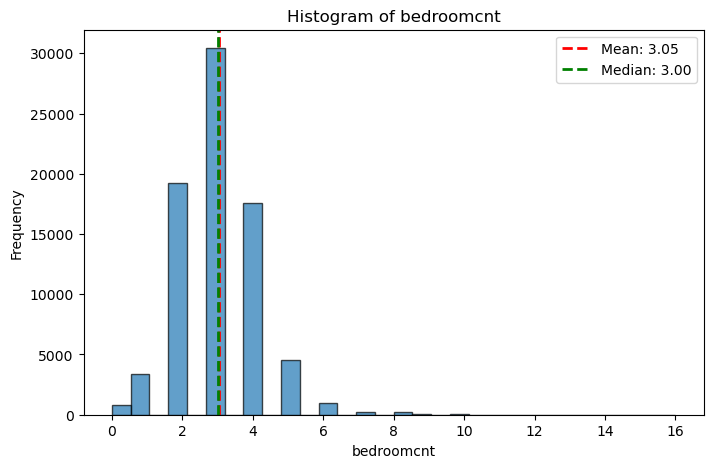

In [474]:
feature = 'bedroomcnt'

# Print statistics
print(f"\nFeature: {feature}")
print(f"Mean: {df[feature].mean():.2f}")
print(f"Median: {df[feature].median():.2f}")
print(f"Max: {df[feature].max()}")
print(f"Min: {df[feature].min()}")

# Calculate the mean and median for the histogram
mean_value = df[feature].mean()
median_value = df[feature].median()

# Plot histogram for the specific feature
plt.figure(figsize=(8, 5))
plt.hist(df[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)  # Drop NaN for histogram
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
plt.title(f"Histogram of {feature}")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.show()


Feature: bathroomcnt
Mean: 2.30
Median: 2.00
Max: 18.0
Min: 0.0


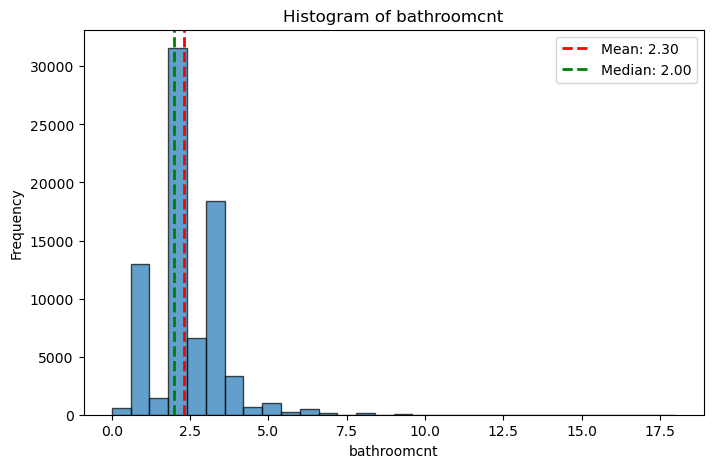

In [475]:
feature = 'bathroomcnt'

# Print statistics
print(f"\nFeature: {feature}")
print(f"Mean: {df[feature].mean():.2f}")
print(f"Median: {df[feature].median():.2f}")
print(f"Max: {df[feature].max()}")
print(f"Min: {df[feature].min()}")

# Calculate the mean and median for the histogram
mean_value = df[feature].mean()
median_value = df[feature].median()

# Plot histogram for the specific feature
plt.figure(figsize=(8, 5))
plt.hist(df[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)  # Drop NaN for histogram
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
plt.title(f"Histogram of {feature}")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.show()


Feature: yearbuilt
Mean: 1968.61
Median: 1970.00
Max: 2016.0
Min: 1824.0


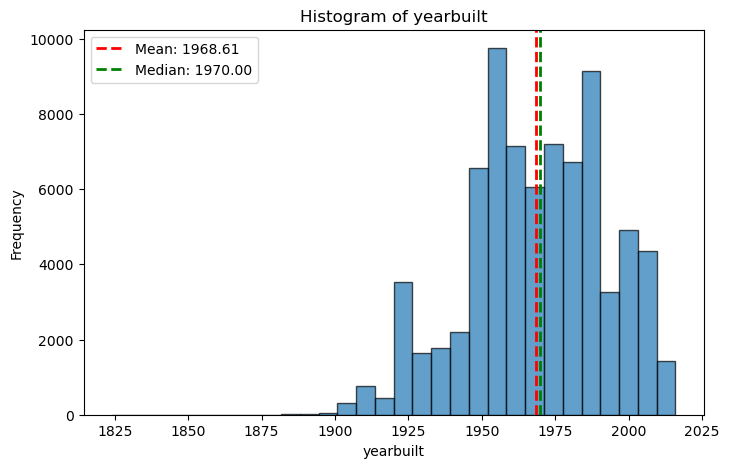

In [476]:
feature = 'yearbuilt'

# Print statistics
print(f"\nFeature: {feature}")
print(f"Mean: {df[feature].mean():.2f}")
print(f"Median: {df[feature].median():.2f}")
print(f"Max: {df[feature].max()}")
print(f"Min: {df[feature].min()}")

# Calculate the mean and median for the histogramåç
mean_value = df[feature].mean()
median_value = df[feature].median()

# Plot histogram for the specific feature
plt.figure(figsize=(8, 5))
plt.hist(df[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)  # Drop NaN for histogram
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
plt.title(f"Histogram of {feature}")
plt.xlabel(feature)
plt.ylabel("Frequency")
plt.legend()
plt.show()


Number of outliers (> 5): 28


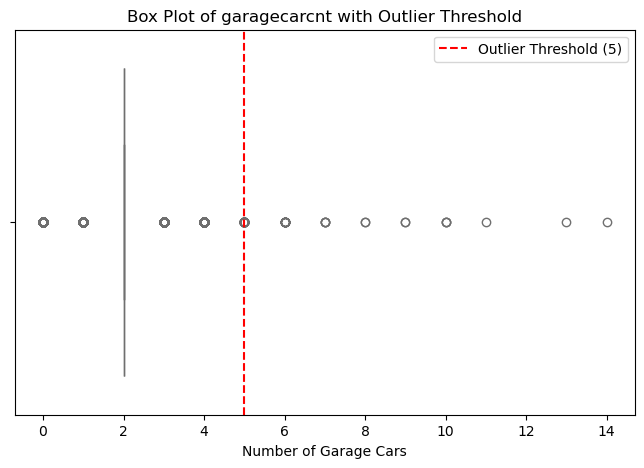

In [477]:
import seaborn as sns
import matplotlib.pyplot as plt

feature = 'garagecarcnt'
outlier_threshold = 5

# Create box plot
plt.figure(figsize=(8, 5))
sns.boxplot(x=df[feature], color='skyblue')
outliers = df[df[feature] > outlier_threshold]
print(f"\nNumber of outliers (> {outlier_threshold}): {len(outliers)}")

# Add outlier threshold line
plt.axvline(outlier_threshold, color='red', linestyle='--', label=f'Outlier Threshold ({outlier_threshold})')

# Customize plot
plt.title(f"Box Plot of {feature} with Outlier Threshold")
plt.xlabel("Number of Garage Cars")
plt.legend()
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?

    ------normal distribution: bedroomcnt, and bathroomcnt

    ------exponential distribution:  taxvaluedollarcnt
- Any problems (e.g., outliers, any odd characteristics)?

    ------ The Number of Garage "garagecarcnt" have some proteitial outliers, with garage nubmer >10, but only 28 samples >5 garage number, we do not need to fix it.

- Anything else interesting? Why did you choose it?
    N/A


## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [478]:
df_dropped = df.drop(columns=['parcelid', 'calculatedbathnbr','finishedsquarefeet12','finishedsquarefeet13','fips','latitude','longitude','pooltypeid10','pooltypeid2','rawcensustractandblock','fireplacecnt','censustractandblock'])


In [479]:
df_dropped.shape[1]

43

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 

These are the features i decided to drop based on cursory review of the column definitions , listed below the columns and why I want to drop them 
1. parcelid  - This just seems like a unique identifier and has no meaning 
2. calculatedbathnbr - Seems like redundant , there are other features providig the bathroomcount 
3. finishedsquarefeet12, 13, 15, 50, 6 - This might be just too much information based on some domain knowledge. Buyer would be interested in finished square feet atleast for the initial round, these parameters shouldnt drastically impact price
4. .fips - seems irrelevant to the buyer
5. latitude, longitude - this seems redundant , the region related features should be able to tell the location
6. poolsizesum, pooltypeid10, 2 - maybe redundant information , as long as buyer knows if there is a pool or spa is enough information and shouldnt drastically change price
7. rawcensustractandblock - doesnt look like relevant info based on domain knowledge
8. fireplacecnt - Redundant since there is already a field called fireplace flag which will tell if there is a fireplace or not which should be sufficient 
9. censustrackandblock - seems irrelevant as well 

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [480]:
# Step 1: Find columns with >60 missing values
missing_threshold = 40000  # set up 4000 here to drop 46639        60.09% 
columns_to_drop = df_dropped.columns[df_dropped.isnull().sum() > missing_threshold]

# Step 2: Drop those columns
df_clean1 = df_dropped.drop(columns=columns_to_drop)

print("Columns dropped:", list(columns_to_drop))


Columns dropped: ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']


In [481]:
# print("Columns dropped:", list(columns_to_drop))
show_null_counts_features(df_clean1)

The dataset contains 77613 samples.

Feature Name                  # Nulls      Null %    Type        UniqueCount
---------------------------    -------      ------    ----       -----------
bathroomcnt                    34           0.04%   Numeric      22
bedroomcnt                     34           0.04%   Numeric      16
propertycountylandusecode      34           0.04%   Categorical  75
propertylandusetypeid          34           0.04%   Numeric      13
regionidcounty                 34           0.04%   Numeric      3
roomcnt                        34           0.04%   Numeric      16
assessmentyear                 34           0.04%   Numeric      1
taxvaluedollarcnt              35           0.05%   Numeric      50949
regionidzip                    84           0.11%   Numeric      389
calculatedfinishedsquarefeet   235          0.30%   Numeric      4972
yearbuilt                      304          0.39%   Numeric      136
fullbathcnt                    650          0.84%   Nume

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped


I decided to drop the columns with >60% Null value. If we keep the columns we need to impute for the missing value by mean (), median (), or Categorical index.

    Limited analytical value: Duplicate rows artificially inflate counts without adding new information.

    Increased complexity: They bloat datasets, slowing processing and potentially skewing results (e.g., overrepresenting certain patterns).


### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


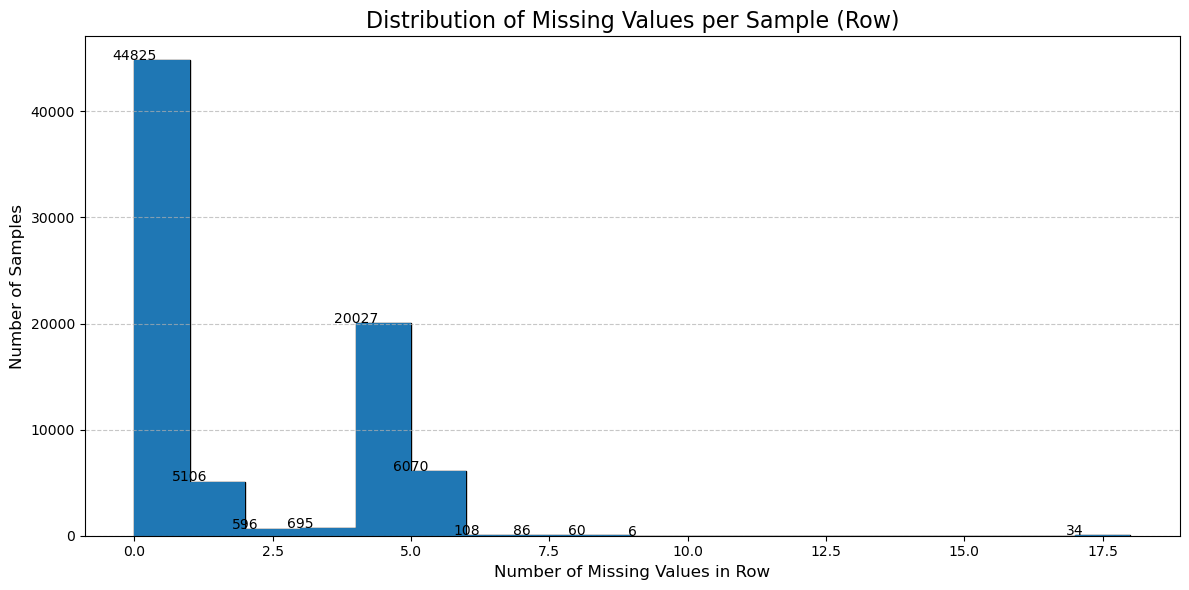

In [482]:
# Calculate nulls per samples, not much, will keep the columns
df_clean1['Nulls_Per_Row'] = df_clean1.isnull().sum(axis=1)
plt.figure(figsize=(12, 6))

# Histogram of null counts per row
plt.hist(
    df_clean1['Nulls_Per_Row'], 
    bins=range(0, df_clean1['Nulls_Per_Row'].max() + 1), 
    color='skyblue', 
    edgecolor='black'
)

# Customize plot
plt.title('Distribution of Missing Values per Sample (Row)', fontsize=16)
plt.xlabel('Number of Missing Values in Row', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with counts
counts, bins, patches = plt.hist(df_clean1['Nulls_Per_Row'], bins=range(0, df_clean1['Nulls_Per_Row'].max() + 1))
for i in range(len(counts)):
    if counts[i] > 0:
        plt.text(bins[i], counts[i] + 5, str(int(counts[i])), ha='center')

plt.tight_layout()
plt.show()

In [483]:
# Check total null values in the target column
null_count = df_clean1['taxvaluedollarcnt'].isnull().sum()
print(f"Number of null values in target column: {null_count}")


Number of null values in target column: 35


In [484]:
#Drop the row without target data
df_clean2 = df_clean1.dropna(subset=['taxvaluedollarcnt']).reset_index(drop=True)

#Drop the featured, created in Null Row count
df_clean2 = df_clean2.drop(columns=['Nulls_Per_Row'])

#Drop useless "assessmentyear", almost all the same value
df_clean2 = df_clean2.drop(columns=['assessmentyear'])


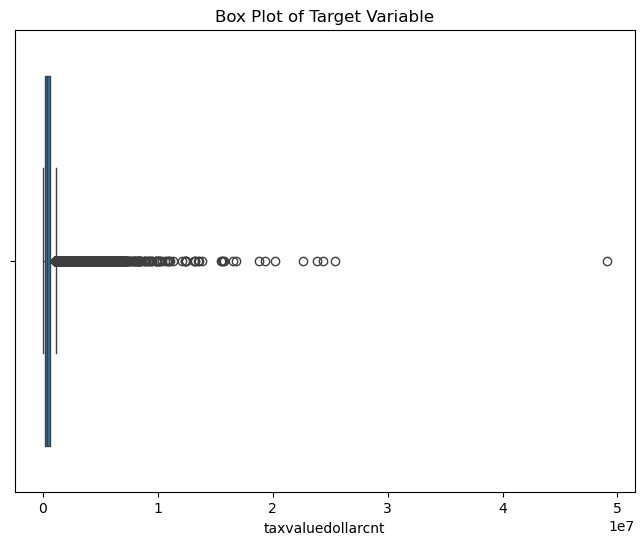

In [485]:
#check if any outliers in the Target, only one data looks like outlier, keep it

import seaborn as sns


plt.figure(figsize=(8, 6))
sns.boxplot(x=df_clean2['taxvaluedollarcnt'])
plt.title("Box Plot of Target Variable")
plt.show()

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


We dropped rows where the target value was missing . we also dropped rows which had >60% of columns missing values. We also drop one column with only one unique value "assessmentyear"

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [486]:
# Separate numeric and categorical features
numeric_features = df_clean2.select_dtypes(include=['number']).columns
categorical_features = df_clean2.select_dtypes(exclude=['number']).columns

# Create copies for imputation
df_imputed = df_clean2.copy()

# Impute numeric features with median
# if len(numeric_features) > 0:
numeric_imputer = SimpleImputer(strategy='median')
df_imputed[numeric_features] = numeric_imputer.fit_transform(df_clean2[numeric_features])

# Impute categorical features with mode (most frequent)
# if len(categorical_features) > 0:
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_imputed[categorical_features] = categorical_imputer.fit_transform(df_clean2[categorical_features])

# Verify no missing values remain
print("Missing values after imputation:")
print(df_imputed.isnull().sum())

Missing values after imputation:
bathroomcnt                     0
bedroomcnt                      0
buildingqualitytypeid           0
calculatedfinishedsquarefeet    0
fullbathcnt                     0
heatingorsystemtypeid           0
lotsizesquarefeet               0
propertycountylandusecode       0
propertylandusetypeid           0
propertyzoningdesc              0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
unitcnt                         0
yearbuilt                       0
taxvaluedollarcnt               0
dtype: int64


In [487]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77578 entries, 0 to 77577
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   77578 non-null  float64
 1   bedroomcnt                    77578 non-null  float64
 2   buildingqualitytypeid         77578 non-null  float64
 3   calculatedfinishedsquarefeet  77578 non-null  float64
 4   fullbathcnt                   77578 non-null  float64
 5   heatingorsystemtypeid         77578 non-null  float64
 6   lotsizesquarefeet             77578 non-null  float64
 7   propertycountylandusecode     77578 non-null  object 
 8   propertylandusetypeid         77578 non-null  float64
 9   propertyzoningdesc            77578 non-null  object 
 10  regionidcity                  77578 non-null  float64
 11  regionidcounty                77578 non-null  float64
 12  regionidzip                   77578 non-null  float64
 13  r

#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


After careful review , the missing numeric values were imputed to median(). Some of the features are int type, like "roomcnt". We choose median() to fit all the numeric values.

Categorical values were imputed 'most_frequent'.


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [488]:
ordinal_encoder = OrdinalEncoder()
# Make a copy of the original dataframe to preserve it
df_encoded = df_imputed.copy()


df_encoded[categorical_features] = ordinal_encoder.fit_transform(df_encoded[categorical_features])
df_encoded.head()


,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedfinishedsquarefeet,fullbathcnt,heatingorsystemtypeid,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt
0,3.5,4.0,6.0,3100.0,3.0,2.0,4506.0,60.0,261.0,580.0,53571.0,1286.0,96978.0,0.0,1.0,1998.0,1023282.0
1,1.0,2.0,6.0,1465.0,1.0,2.0,12647.0,51.0,261.0,580.0,13091.0,2061.0,97099.0,5.0,1.0,1967.0,464000.0
2,2.0,3.0,6.0,1243.0,2.0,2.0,8432.0,60.0,261.0,580.0,21412.0,1286.0,97078.0,6.0,1.0,1962.0,564778.0
3,3.0,4.0,8.0,2376.0,3.0,2.0,13038.0,1.0,261.0,797.0,396551.0,3101.0,96330.0,0.0,1.0,1970.0,145143.0
4,3.0,3.0,8.0,1312.0,3.0,2.0,278581.0,8.0,266.0,587.0,12447.0,3101.0,96451.0,0.0,1.0,1964.0,119407.0


In [489]:
# Check if any missing values
def has_nan(df: pd.DataFrame) -> bool:
    """Returns False if the ENTIRE dataset has NO NaN values, True otherwise."""
    return df.isna().any().any()

# Usage:
df = df_encoded
print(has_nan(df))  # Output: False (no NaNs)

False


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

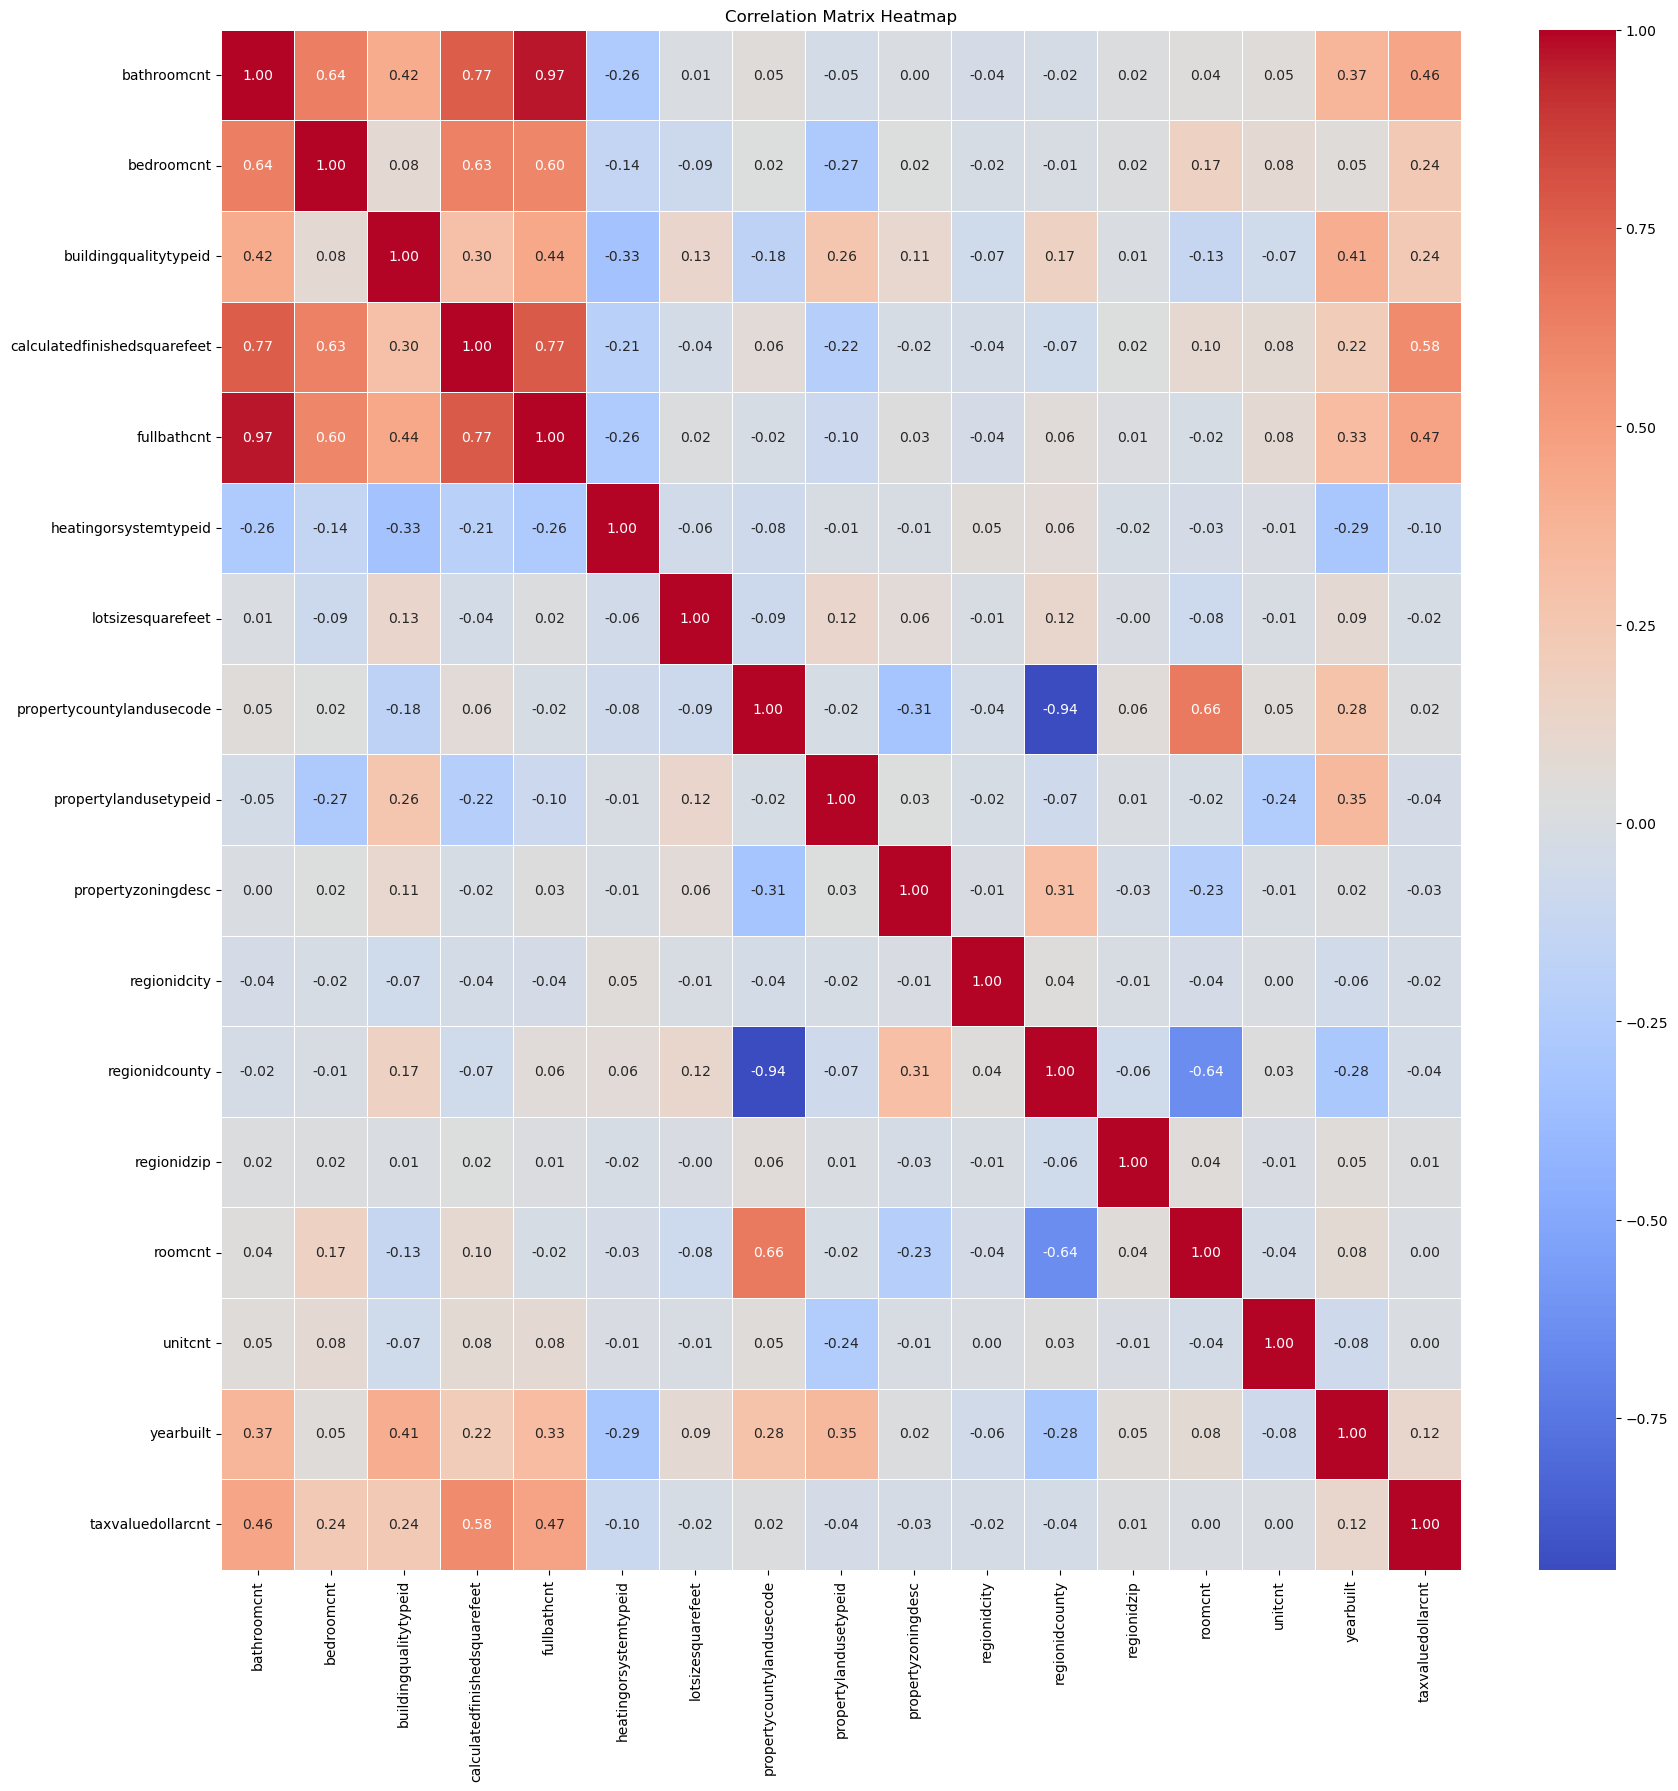

In [490]:
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(20, 20))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title("Correlation Matrix Heatmap")

# Show the plot
plt.show()


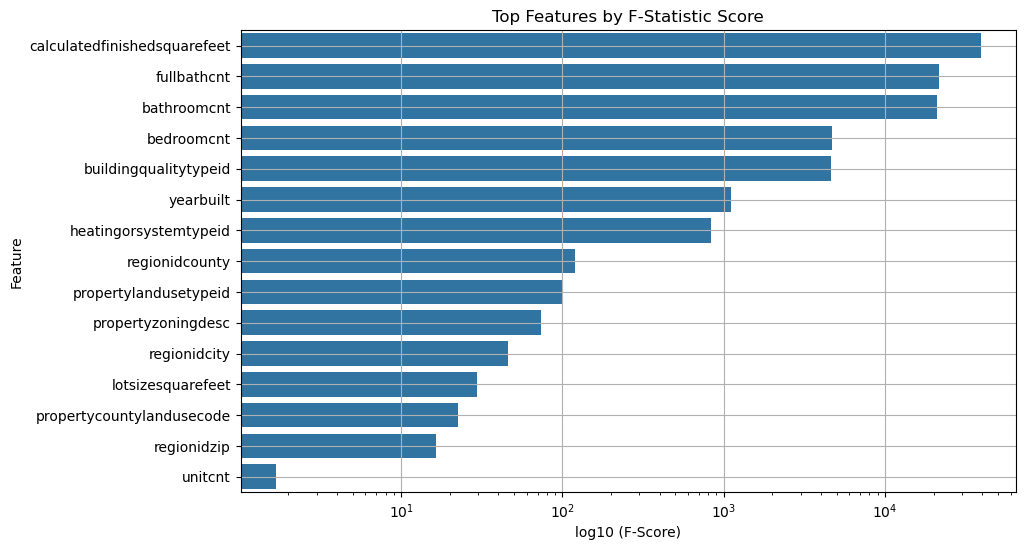

Top Features by F-Statistic:
                         Feature       F-Score        P-Value
3   calculatedfinishedsquarefeet  39046.634476   0.000000e+00
4                    fullbathcnt  21427.245430   0.000000e+00
0                    bathroomcnt  20937.303354   0.000000e+00
1                     bedroomcnt   4713.271746   0.000000e+00
2          buildingqualitytypeid   4615.850048   0.000000e+00
15                     yearbuilt   1105.190813  1.222386e-240
5          heatingorsystemtypeid    827.393946  5.369273e-181
11                regionidcounty    119.797050   7.344536e-28
8          propertylandusetypeid    100.278591   1.368452e-23
9             propertyzoningdesc     73.967339   8.087038e-18
10                  regionidcity     45.726773   1.369107e-11
6              lotsizesquarefeet     29.371450   5.992897e-08
7      propertycountylandusecode     22.477542   2.129916e-06
12                   regionidzip     16.358368   5.247483e-05
14                       unitcnt      1.6

In [491]:
df_clean3=df_encoded

scaler = StandardScaler()

X = df_clean3.drop('taxvaluedollarcnt', axis=1)
y = df_clean3['taxvaluedollarcnt']

X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Compute F-statistics and p-values
f_scores, p_values = f_regression(X_scaled, y_scaled.ravel())  # ravel() flattens y


f_stats = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
}).sort_values('F-Score', ascending=False)

# Plot F-statistics
plt.figure(figsize=(10, 6))
plt.xscale("log")
sns.barplot(x='F-Score', y='Feature', data=f_stats.head(15))
plt.title('Top Features by F-Statistic Score')
plt.xlabel('log10 (F-Score)')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

print("Top Features by F-Statistic:")
print(f_stats.head(20))


/var/folders/1d/75z2d_qj2cz000ycq8lq5qdr0000gn/T/ipykernel_61323/3759109903.py:45: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


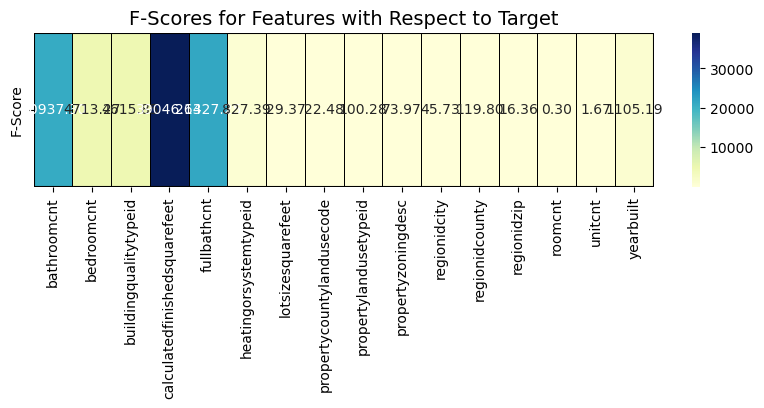

/var/folders/1d/75z2d_qj2cz000ycq8lq5qdr0000gn/T/ipykernel_61323/3759109903.py:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


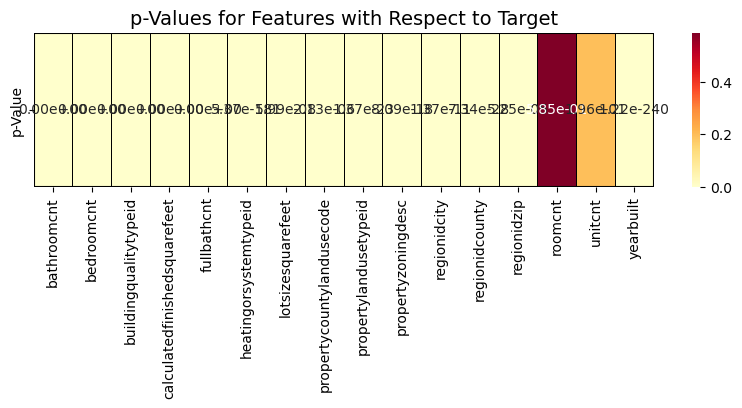

In [492]:

# Displaying F-Scores and p-values

from matplotlib import patches
X = df_clean3.drop('taxvaluedollarcnt', axis=1)
y = df_clean3['taxvaluedollarcnt']

# Scale the features and response for proper F-score; not necessary for calculating p-value.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()             

# Compute F-scores and p-values using f_regression
f_scores, p_values = f_regression(X_scaled, y_scaled)

# Create DataFrames for F-scores and p-values
f_score_matrix = pd.DataFrame(f_scores.reshape(1, -1), columns=X.columns, index=["F-Score"])
p_value_matrix = pd.DataFrame(p_values.reshape(1, -1), columns=X.columns, index=["p-Value"])

# Plot the F-score heatmap
plt.figure(figsize=(10, 2))
ax = sns.heatmap(
    f_score_matrix,
    annot=True,
    cmap="YlGnBu",
    cbar=True,
    fmt=".2f",
    linewidths=0.5,  # Thickness of the cell edges
    linecolor="black",  # Black edges between cells
    xticklabels=f_score_matrix.columns,
    yticklabels=f_score_matrix.index
)

# Add a consistent black border around the entire heatmap
ax.add_patch(patches.Rectangle(
    (0, 0),  # Bottom-left corner
    f_score_matrix.shape[1],  # Width (number of columns)
    f_score_matrix.shape[0],  # Height (number of rows)
    edgecolor='black',  # Border color
    fill=False,  # Do not fill the rectangle
    lw=1.5  # Line width of the border
))

plt.title("F-Scores for Features with Respect to Target", fontsize=14)
plt.tight_layout()
plt.show()


# Plot the p-value heatmap
plt.figure(figsize=(10, 2))
ax = sns.heatmap(
    p_value_matrix,
    annot=True,
    cmap="YlOrRd",
    cbar=True,
    fmt=".2e",
    linewidths=0.5,  # Thickness of the cell edges
    linecolor="black",  # Black edges between cells
    xticklabels=p_value_matrix.columns,
    yticklabels=p_value_matrix.index
)

# Add a consistent border around the entire heatmap
ax.add_patch(patches.Rectangle(
    (0, 0),  # Bottom-left corner
    p_value_matrix.shape[1],  # Width (number of columns)
    p_value_matrix.shape[0],  # Height (number of rows)
    edgecolor='black',  # Border color
    fill=False,  # Do not fill the rectangle
    lw=1.5  # Line width of the border
))

plt.title("p-Values for Features with Respect to Target", fontsize=14)
plt.tight_layout()
plt.show()

/var/folders/1d/75z2d_qj2cz000ycq8lq5qdr0000gn/T/ipykernel_61323/2029839257.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


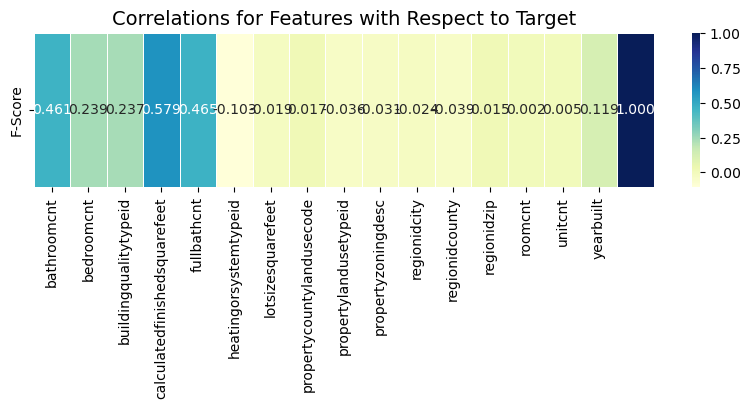

In [493]:
# correlation_matrix[['Target']]

# Plot the F-score heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(correlation_matrix[-1:], annot=True, cmap="YlGnBu", cbar=True, fmt=".3f",
            linewidths=0.5, xticklabels=f_score_matrix.columns, yticklabels=f_score_matrix.index)
plt.title("Correlations for Features with Respect to Target", fontsize=14)
plt.tight_layout()
plt.show()

In [494]:
#split the data for regression
X = df_clean3.drop('taxvaluedollarcnt', axis = 1)
y = df_clean3['taxvaluedollarcnt']


test_size = 0.2      # with very small datasets, this might work better. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=random_state)

len(X),len(y),len(X_train), len(y_train),len(X_test),len(y_test)

(77578, 77578, 62062, 62062, 15516, 15516)

In [495]:
#FORWARD SELECTION 
def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv=5, 
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"                                      
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score
    
    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far
    
    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]
            
            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = (-cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean())**0.5
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]
            
        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (RMSE): {current_score:.4f}")
        
        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()
        
        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )



Features: ['calculatedfinishedsquarefeet'], CV Score (RMSE): 533634.8313

Features: ['calculatedfinishedsquarefeet', 'bedroomcnt'], CV Score (RMSE): 523447.5644

Features: ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt'], CV Score (RMSE): 521027.1001

Features: ['bedroomcnt', 'bathroomcnt', 'yearbuilt'], CV Score (RMSE): 519574.8462

Features: ['bathroomcnt', 'yearbuilt', 'propertylandusetypeid'], CV Score (RMSE): 517352.3735

Features: ['yearbuilt', 'propertylandusetypeid', 'buildingqualitytypeid'], CV Score (RMSE): 517203.6140

Features: ['propertylandusetypeid', 'buildingqualitytypeid', 'regionidcounty'], CV Score (RMSE): 516925.5050

Features: ['buildingqualitytypeid', 'regionidcounty', 'roomcnt'], CV Score (RMSE): 516202.4261

Features: ['regionidcounty', 'roomcnt', 'propertycountylandusecode'], CV Score (RMSE): 515905.2135

Features: ['roomcnt', 'propertycountylandusecode', 'heatingorsystemtypeid'], CV Score (RMSE): 515773.4634

Features: ['propertycountylandusecode

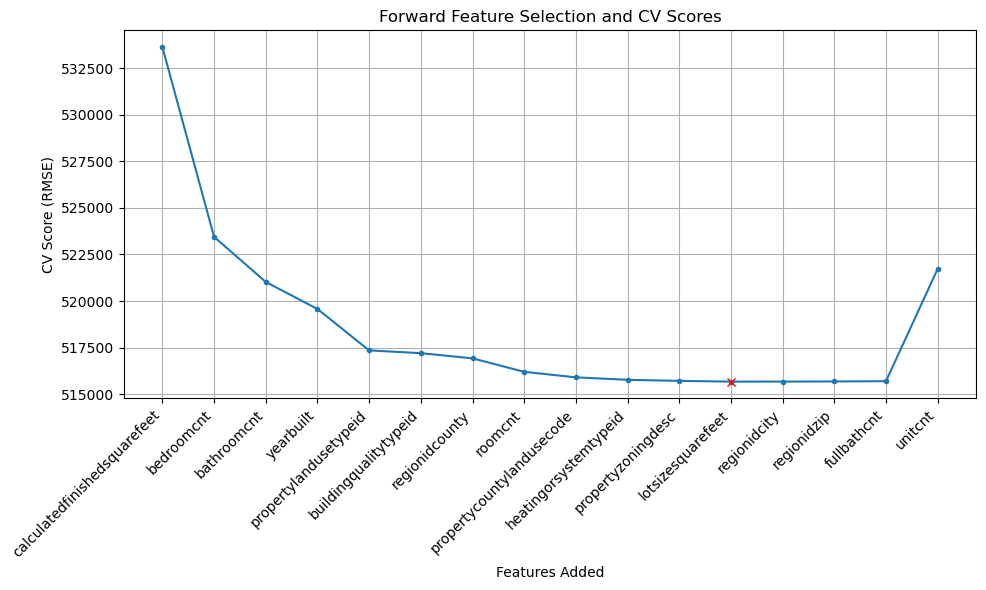

Best Features: ['calculatedfinishedsquarefeet', 'bedroomcnt', 'bathroomcnt', 'yearbuilt', 'propertylandusetypeid', 'buildingqualitytypeid', 'regionidcounty', 'roomcnt', 'propertycountylandusecode', 'heatingorsystemtypeid', 'propertyzoningdesc', 'lotsizesquarefeet']
Best CV Score: 515676.7622
Test MSE: 643165.7966


In [496]:
# Run Forward Feature Selection

model = LinearRegression()

selected_features, best_scores, best_forward_features, best_score =    (
            forward_feature_selection(X, y, model, verbose=True) )

# Plot the results

index = np.argmax(np.array(selected_features) == best_forward_features[-1])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
plt.plot([index+1],best_score,marker='x',color='red')
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and score
print(f"Best Features: {best_forward_features}")
print(f"Best CV Score: {best_score:.4f}")

# Testing

# Filter X_train and X_test to include only the selected features
X_train_best = X_train[best_forward_features]
X_test_best = X_test[best_forward_features]

# Run the test set through the model
model = LinearRegression()
model.fit(X_train_best, y_train)

y_pred = model.predict(X_test_best)

test_mse = mean_squared_error(y_test, y_pred)**0.5

print(f"Test MSE: {test_mse:.4f}")

In [497]:
# Backward selection algorithm

def backward_feature_selection(X, y, model, 
                                      scoring='neg_mean_squared_error', 
                                      cv=5, 
                                      tol=None,               # None = no delta cutoff
                                                              # use 0.0 for "no further improvements"
                                                              # and 1e-4 for "point of diminishing returns"                                      
                                      max_features=None,      # None = use all features
                                      n_jobs = -1,
                                      verbose=True
                                     ):
    
    def cv_score(features):
        return -cross_val_score(LinearRegression(), X[features], y, 
                                scoring=scoring, cv=cv, n_jobs=n_jobs).mean()

    features_remaining = np.array(X.columns)
    scores = [ (features_remaining,'None',cv_score(features_remaining))]   # (feature removed, cv score after removed)

    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {scores[0][2]}\n')

    if max_features == None:
        max_features = len(X.columns)
     
    prev_score = float('inf')
    for i in range(1,max_features):
        if verbose:
            print(f'Round {i}:')
        # calculate cv score for every possible removal of a feature
        lowest_score = (None,None,float('inf'))

        for k in range(len(features_remaining)):
            new_feature_set = np.delete(features_remaining,k)    # np.delete makes a copy and then deletes
            new_score = cv_score(new_feature_set)
            if verbose:
                print(new_feature_set, features_remaining[k], np.around(new_score,4))
            if new_score < lowest_score[2]:
                lowest_score = (new_feature_set,features_remaining[k],new_score)
            
        # Check if improvement is below the tolerance
        if tol is not None and (prev_score - lowest_score[2]) < tol:
            print("\nStopping early due to minimal improvement.")
            break
            
        prev_score = lowest_score[2]
        
        features_remaining = lowest_score[0]
        scores.append(lowest_score)
        if verbose:
            print(f'\nRemoving {lowest_score[1]}:  CV score (RMSE) {np.around(lowest_score[2]) }\n')

        
           
    return scores

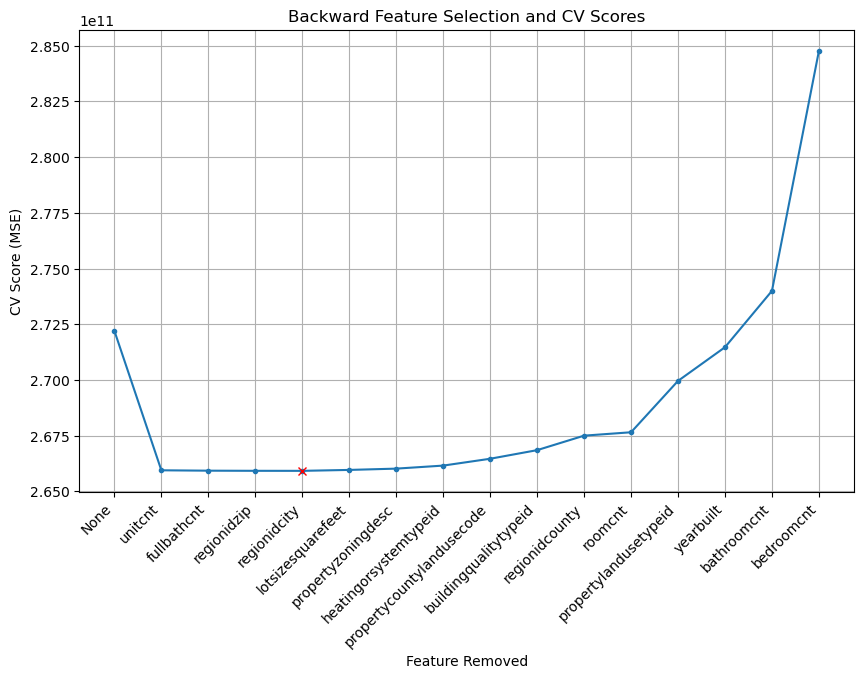

Best feature set: ['bathroomcnt' 'bedroomcnt' 'buildingqualitytypeid'
 'calculatedfinishedsquarefeet' 'heatingorsystemtypeid'
 'lotsizesquarefeet' 'propertycountylandusecode' 'propertylandusetypeid'
 'propertyzoningdesc' 'regionidcounty' 'roomcnt' 'yearbuilt']
CV score (RMSE): 515676.7622
Test MSE: 643165.7966


In [498]:
# run ç selection and display results

scores = backward_feature_selection(X, y, model, 
                                      scoring='neg_mean_squared_error', 
                                      cv=5, 
                                      tol=None,             # None = no delta cutoff
                                                            # use 0.0 for "no further improvements"
                                                            # and 1e-4 for "point of diminishing returns"                                      
                                      max_features=None,    # None = use all features
                                      verbose=False
                                     )

x_axis, y_axis = np.array( [sc[1] for sc in scores] ), np.array( [sc[2] for sc in scores] ) 

(best_feature_set, feature_removed, best_score) = min(scores, key=lambda sc: sc[2])
index = np.argmax(np.array(x_axis) == feature_removed)

plt.figure(figsize=(10,6))
plt.title("Backward Feature Selection and CV Scores")
plt.plot(x_axis,y_axis,marker='.')
plt.plot([index],best_score,marker='x',color='red')
plt.xlabel('Feature Removed')
plt.ylabel('CV Score (MSE)')
plt.xticks(range(len(x_axis)),x_axis, rotation=45, ha='right')
plt.grid()
plt.show()


# Print minimum cv score

print("Best feature set:", best_feature_set)
print("CV score (RMSE):",np.around(best_score**0.5,4))

# Test

# Filter X_train and X_test to include only the selected features
X_train_best_backward = X_train[best_feature_set]
X_test_best_backward = X_test[best_feature_set]

# Train the LinearRegression model on the selected features
model = LinearRegression()
model.fit(X_train_best_backward, y_train)

# Predict on the test set
y_pred = model.predict(X_test_best_backward)

# Calculate the test MSE
test_mse = (mean_squared_error(y_test, y_pred))**0.5

print(f"Test MSE: {test_mse:.4f}")

#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



We used the heatmap to show the correlation between the different numerical features along with the scaled dollar value. We could clearly see correlations between these features, used data from the heatmap where the value was more than 0.6 or 0.7 
1. architecturestyletype with constructiontype 
2. bathrmcnt with fullbathcnt
3. bedroomcnt with bathrmcnt 
4. buildingquality with regioncounty. 
5. fullbathcnt with calculatedfinishedsquarefeet
6. roomcnt with numberofstories 

Then we used Forward/backward Feature selection and it resulted in 15 best features. We will use pair plot against these 15 features to understand the feature relationships better via visualization in next question 

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 1200x1200 with 0 Axes>

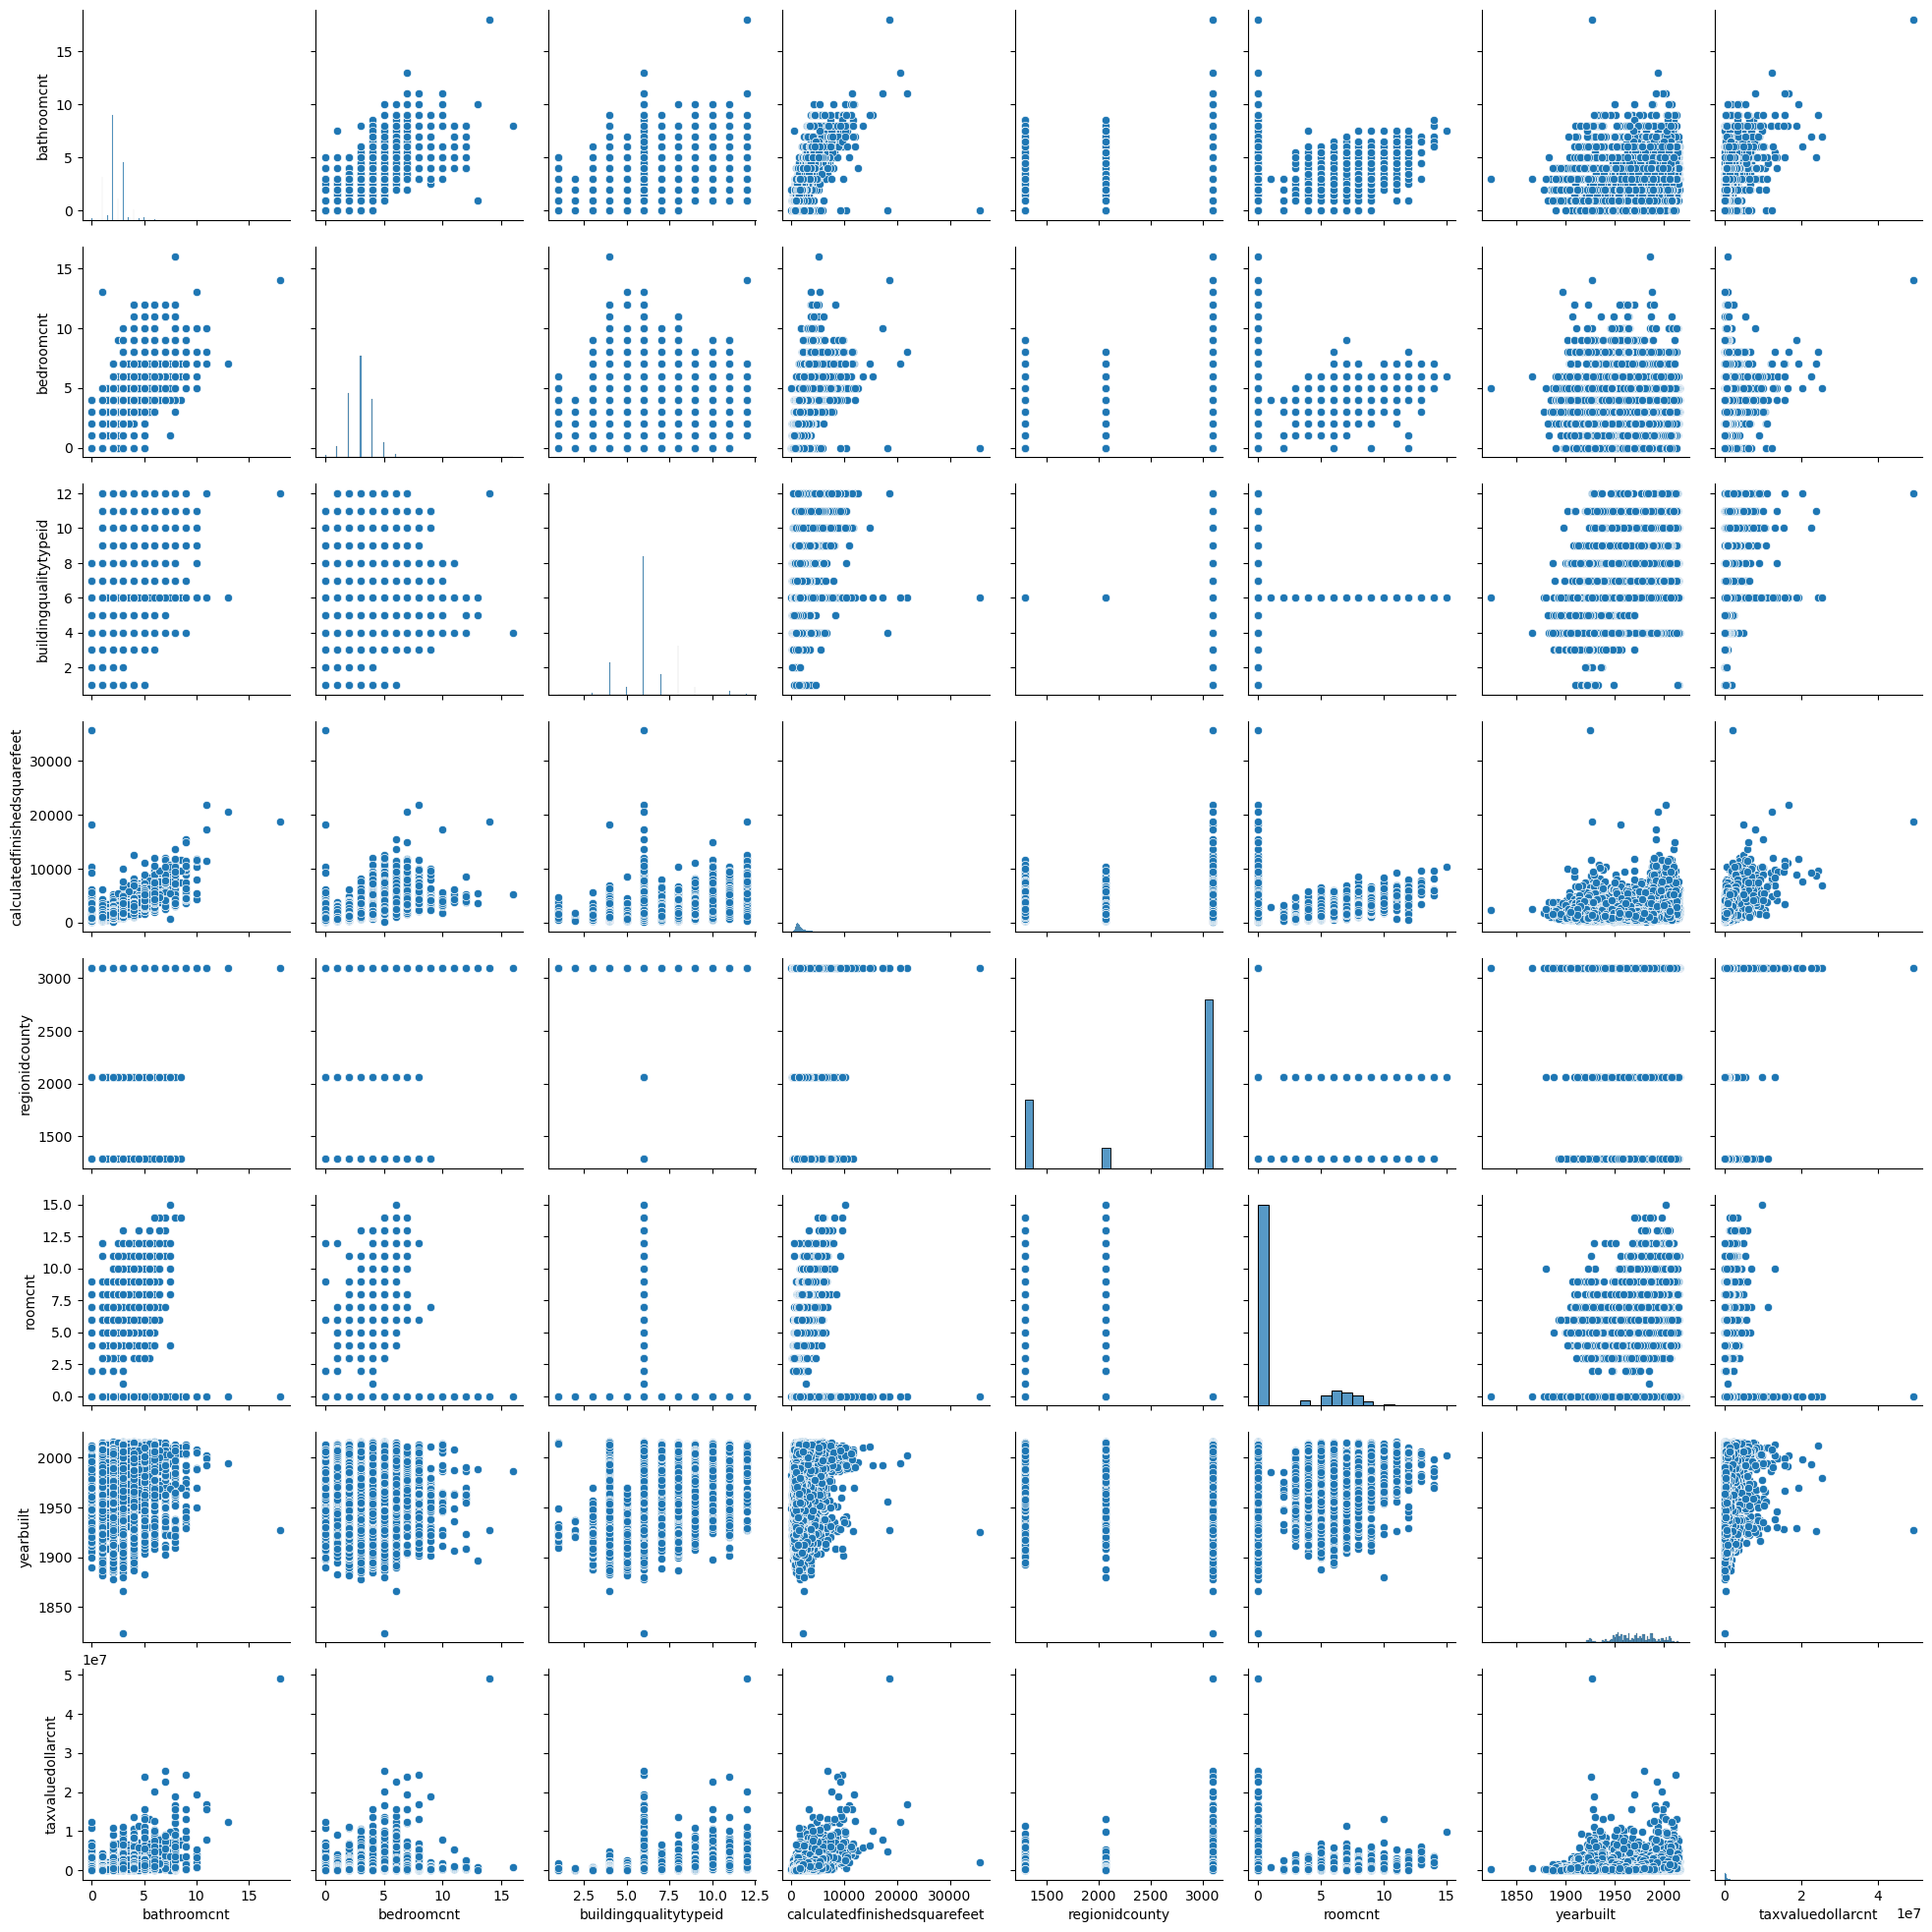

In [499]:
#WE WILL SEE THE FOLLOWING 3 PAIRS OF FEARURES FROM ABOVE 
# 3. bedroomcnt with bathrmcnt 
# 4. buildingquality with taxvaluedollarcnt. 
# 5. taxvaluedollarcnt with yearbuilt

plt.figure(figsize=(12,12))
myfeatures = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet',
   'regionidcounty', 'roomcnt', 'yearbuilt','taxvaluedollarcnt']
selected_data = df_clean3[myfeatures]
sns.pairplot(selected_data)
plt.show



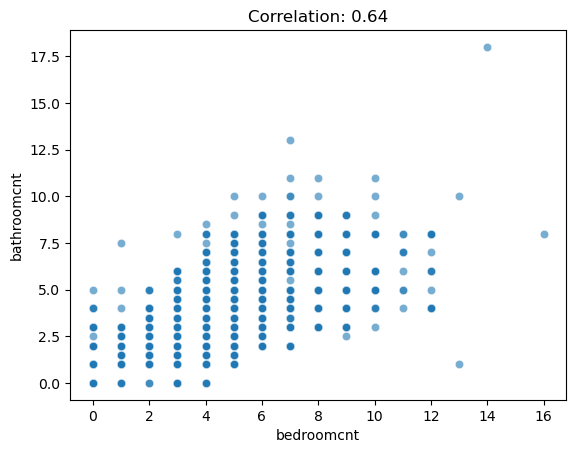

In [500]:
# Plot 1: Bedrooms vs Bathrooms
sns.scatterplot(data=df_clean3, x='bedroomcnt', y='bathroomcnt', alpha=0.6)
plt.title(f"Correlation: {df_clean3['bedroomcnt'].corr(df_clean3['bathroomcnt']):.2f}")
plt.show()

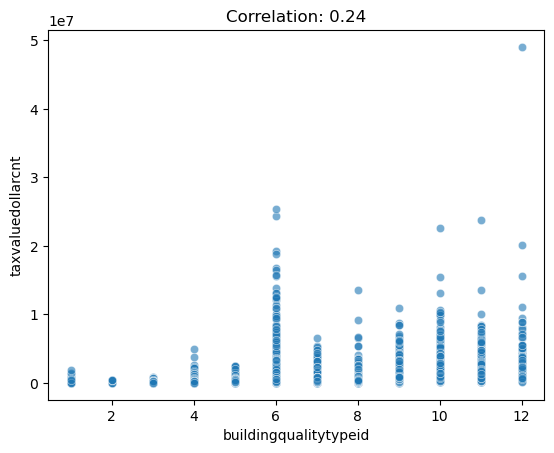

In [501]:
# Plot 2: Building Quality vs Tax Value
sns.scatterplot(data=df_clean3, x='buildingqualitytypeid', y='taxvaluedollarcnt', alpha=0.6)
plt.title(f"Correlation: {df_clean3['buildingqualitytypeid'].corr(df_clean3['taxvaluedollarcnt']):.2f}")
plt.show()

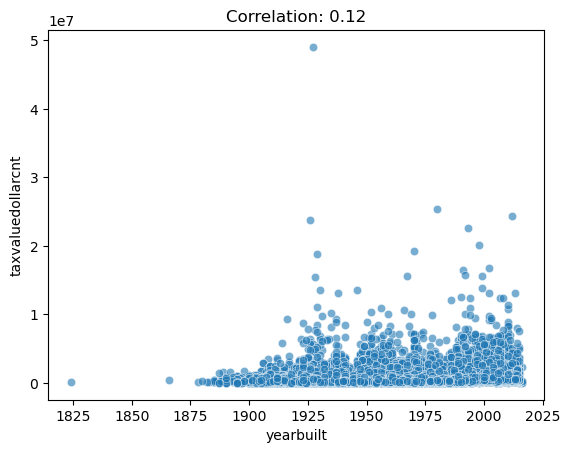

In [502]:
# Plot 3: Year Built vs Tax Value
sns.scatterplot(data=df_clean3, x='yearbuilt', y='taxvaluedollarcnt', alpha=0.6)
plt.title(f"Correlation: {df_clean3['yearbuilt'].corr(df_clean3['taxvaluedollarcnt']):.2f}")
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


We used pairplots as suggested ,also included the target column so we could see the relationship between each of the pairs of features as well as its relationship to the target dollar value. 
Its clear from the heatmap , the forward selected features and the pair plot - the relationships between the features chosen and the target are really correlated 

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

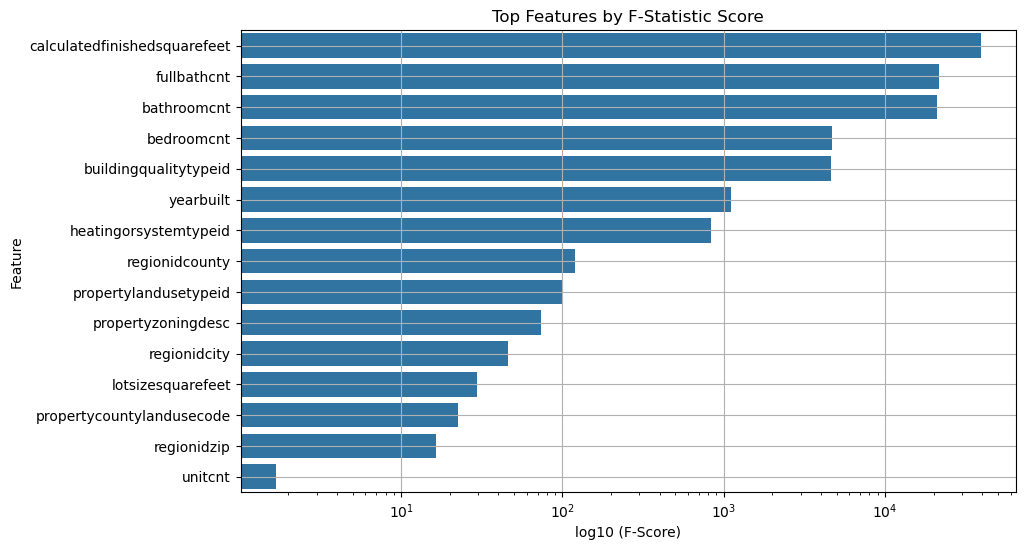

Top Features by F-Statistic:
                         Feature       F-Score        P-Value
3   calculatedfinishedsquarefeet  39046.634476   0.000000e+00
4                    fullbathcnt  21427.245430   0.000000e+00
0                    bathroomcnt  20937.303354   0.000000e+00
1                     bedroomcnt   4713.271746   0.000000e+00
2          buildingqualitytypeid   4615.850048   0.000000e+00
15                     yearbuilt   1105.190813  1.222386e-240
5          heatingorsystemtypeid    827.393946  5.369273e-181
11                regionidcounty    119.797050   7.344536e-28
8          propertylandusetypeid    100.278591   1.368452e-23
9             propertyzoningdesc     73.967339   8.087038e-18
10                  regionidcity     45.726773   1.369107e-11
6              lotsizesquarefeet     29.371450   5.992897e-08
7      propertycountylandusecode     22.477542   2.129916e-06
12                   regionidzip     16.358368   5.247483e-05
14                       unitcnt      1.6

In [503]:
# Transformation-1: Feacture scaling 
df_clean3 = df_encoded.copy()  # Avoid modifying original data

# Separate features and target
X = df_clean3.drop('taxvaluedollarcnt', axis=1)
y = df_clean3['taxvaluedollarcnt']

# Apply StandardScaler to features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize features
y_scaled = y  # No need to scale y for f_regression

# Compute F-statistics and p-values
f_scores, p_values = f_regression(X_scaled, y_scaled)

# Store results in a DataFrame
f_stats = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
}).sort_values('F-Score', ascending=False)

# Plot F-statistics
plt.figure(figsize=(10, 6))
plt.xscale("log")
sns.barplot(x='F-Score', y='Feature', data=f_stats.head(15))
plt.title('Top Features by F-Statistic Score')
plt.xlabel('log10 (F-Score)')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

print("Top Features by F-Statistic:")
print(f_stats.head(20))

In [504]:
# Transformation-2: Decompose categorical into One-Hot feature sequence

# Step 1: Create a clean copy of the data
df_clean4 = df_imputed.copy()
df_clean4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77578 entries, 0 to 77577
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   77578 non-null  float64
 1   bedroomcnt                    77578 non-null  float64
 2   buildingqualitytypeid         77578 non-null  float64
 3   calculatedfinishedsquarefeet  77578 non-null  float64
 4   fullbathcnt                   77578 non-null  float64
 5   heatingorsystemtypeid         77578 non-null  float64
 6   lotsizesquarefeet             77578 non-null  float64
 7   propertycountylandusecode     77578 non-null  object 
 8   propertylandusetypeid         77578 non-null  float64
 9   propertyzoningdesc            77578 non-null  object 
 10  regionidcity                  77578 non-null  float64
 11  regionidcounty                77578 non-null  float64
 12  regionidzip                   77578 non-null  float64
 13  r

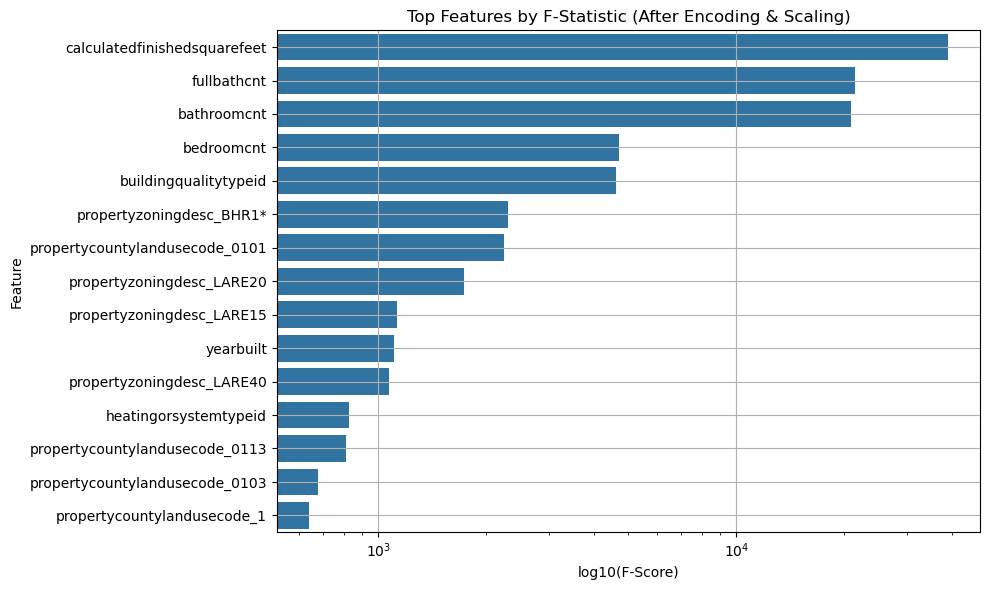

Top Features by F-Statistic:
                             Feature       F-Score        P-Value
3       calculatedfinishedsquarefeet  39046.634476   0.000000e+00
4                        fullbathcnt  21427.245430   0.000000e+00
0                        bathroomcnt  20937.303354   0.000000e+00
1                         bedroomcnt   4713.271746   0.000000e+00
2              buildingqualitytypeid   4615.850048   0.000000e+00
153         propertyzoningdesc_BHR1*   2298.563798   0.000000e+00
1920  propertycountylandusecode_0101   2250.244079   0.000000e+00
620        propertyzoningdesc_LARE20   1733.385287   0.000000e+00
619        propertyzoningdesc_LARE15   1127.941683  1.631786e-245
13                         yearbuilt   1105.190813  1.222386e-240
621        propertyzoningdesc_LARE40   1070.781853  2.900272e-233
5              heatingorsystemtypeid    827.393946  5.369273e-181
1938  propertycountylandusecode_0113    814.653891  2.956224e-178
1922  propertycountylandusecode_0103    679.094

In [505]:
# Step 2: One-Hot Encode Categorical Features
categorical_features = ['propertyzoningdesc', 'propertycountylandusecode']
df_clean4 = pd.get_dummies(
    df_clean4, 
    columns=categorical_features,
    prefix=categorical_features,  # Adds feature name prefix
    drop_first=True  # Avoids dummy variable trap
)

# Step 3: Separate features and target
X = df_clean4.drop('taxvaluedollarcnt', axis=1)
y = df_clean4['taxvaluedollarcnt']

# Step 4: Identify numerical features (excluding target)
numerical_features = X.select_dtypes(include=['int64','float64']).columns

# Step 5: Scale only numerical features (preserving one-hot encoded 0/1 values)
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Step 6: Compute F-statistics
f_scores, p_values = f_regression(X, y)

# Step 7: Store and visualize results
f_stats = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
}).sort_values('F-Score', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
plt.xscale("log")
sns.barplot(x='F-Score', y='Feature', data=f_stats.head(15))
plt.title('Top Features by F-Statistic (After Encoding & Scaling)')
plt.xlabel('log10(F-Score)')
plt.ylabel('Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Top Features by F-Statistic:")
print(f_stats.head(20))

# Verify new one-hot encoded columns
print("\nNew one-hot encoded columns:")
print([col for col in X.columns if any(cat in col for cat in categorical_features)])

In [506]:
df_clean3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77578 entries, 0 to 77577
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   77578 non-null  float64
 1   bedroomcnt                    77578 non-null  float64
 2   buildingqualitytypeid         77578 non-null  float64
 3   calculatedfinishedsquarefeet  77578 non-null  float64
 4   fullbathcnt                   77578 non-null  float64
 5   heatingorsystemtypeid         77578 non-null  float64
 6   lotsizesquarefeet             77578 non-null  float64
 7   propertycountylandusecode     77578 non-null  float64
 8   propertylandusetypeid         77578 non-null  float64
 9   propertyzoningdesc            77578 non-null  float64
 10  regionidcity                  77578 non-null  float64
 11  regionidcounty                77578 non-null  float64
 12  regionidzip                   77578 non-null  float64
 13  r

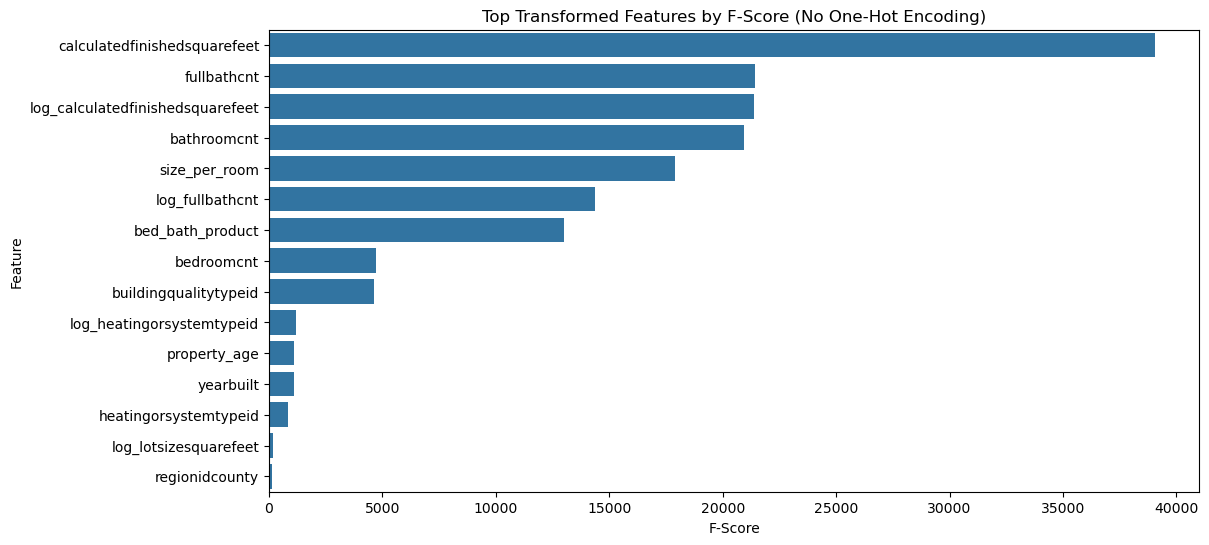

Top Transformed Features:
                             Feature       F-Score        P-Value
3       calculatedfinishedsquarefeet  39046.634476   0.000000e+00
4                        fullbathcnt  21427.245430   0.000000e+00
16  log_calculatedfinishedsquarefeet  21389.922471   0.000000e+00
0                        bathroomcnt  20937.303354   0.000000e+00
25                     size_per_room  17902.922587   0.000000e+00
17                   log_fullbathcnt  14351.279274   0.000000e+00
24                  bed_bath_product  12995.793320   0.000000e+00
1                         bedroomcnt   4713.271746   0.000000e+00
2              buildingqualitytypeid   4615.850048   0.000000e+00
18         log_heatingorsystemtypeid   1181.612899  5.237448e-257
26                      property_age   1105.190813  1.222386e-240
15                         yearbuilt   1105.190813  1.222386e-240
5              heatingorsystemtypeid    827.393946  5.369273e-181
19             log_lotsizesquarefeet    180.135588

In [507]:
# Transformation-3: Promising transformations of features

df_transformed = df_clean3.copy()
X = df_transformed.drop('taxvaluedollarcnt', axis=1)
y = df_transformed['taxvaluedollarcnt']

# Step 2: Identify and Apply Log Transformation to Right-Skewed Features
skew_threshold = 1  # Define threshold for skewness
skewed_features = X.skew().abs()  # Compute absolute skewness
log_features = skewed_features[skewed_features > skew_threshold].index.tolist()  # Pick highly skewed features

# Apply log(1+x) transformation
for feat in log_features:
    if (X[feat] > 0).all():  # Ensure all values are positive before applying log
        X[f'log_{feat}'] = np.log1p(X[feat])

# Step 3: Generate Additional Features
X['bed_bath_product'] = X['bedroomcnt'] + X['bathroomcnt']
X['size_per_room'] = X['calculatedfinishedsquarefeet'] / (X['roomcnt'] + 1e-6)  # Avoid divide-by-zero

    # Create "property age" feature
current_year = pd.Timestamp.now().year
X['property_age'] = current_year - X['yearbuilt']

# Step 4: Scale Numerical Features (including transformed ones)
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Step 5: Compute F-Statistics
f_scores, p_values = f_regression(X, y)

# Step 6: Analyze Results
f_stats = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
}).sort_values('F-Score', ascending=False)

# Plot top transformed features
plt.figure(figsize=(12, 6))
sns.barplot(x='F-Score', y='Feature', data=f_stats.head(15))
plt.title('Top Transformed Features by F-Score (No One-Hot Encoding)')
plt.show()

print("Top Transformed Features:")
print(f_stats.head(15))


#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


Reason: 

Scaling---It is simple, and ensure the numerical features contribute equally

Decompose features---Check if any hiden pattern

Feature transfomration---It fit more the real complex data

Observation:

Scaling---not help with the analysis

Decompose features---limited help

Feature transfomration---Some new interesting features, like "property_age" and "size_per_room", may help with the analysis

Overall the Feature Engineering does not change the pattern, but it worth to dig into.


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

